# **Importing Libraries**

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
!pip install opendatasets
!pip install joblib

In [ ]:
import opendatasets as od
import joblib
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import random
from keras.preprocessing.image import load_img
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp
from scipy.stats import mode
import seaborn as sns

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the directory to save models
models_directory = '/content/drive/My Drive/models'

Mounted at /content/drive


# **Downloading the dataset**

If you want to run, provide your Kaggle credentials below

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zhaaaoo
Your Kaggle Key: ··········


100%|██████████| 82.0M/82.0M [00:01<00:00, 74.0MB/s]


# **Displaying the dataset**

This code defines a function, `display_random_images`, which is designed to visually explore the dataset by displaying a specified number of random images from different classes. It operates on a dataset organized in a directory structure where each class has its own subdirectory. Here's a detailed explanation of the function that you can use in a Colab notebook text cell:

---

This function, `display_random_images`, serves to showcase a sample of images from a structured dataset, where images are categorized into classes, each within its own subdirectory. The purpose is to provide a quick visual inspection of the dataset's diversity and class representation. The function's operation can be broken down into several key steps:

1. **Directory Listing**: It starts by creating a list of class directories within the base dataset path. This is achieved by iterating over all items in the base directory, filtering for directories only. This step ensures that each class is represented.

2. **Figure Setup**: Prepares a matplotlib figure with a specified size, designed to accommodate the display of multiple images in a single row.

3. **Random Image Display**: For each image to be displayed (as specified by `num_images`), the function performs the following actions:
   - **Class Selection**: Randomly selects one of the class directories, ensuring that the displayed images may come from any of the available classes, providing a varied sample.
   - **Image Selection**: Within the chosen class directory, it randomly selects an image file. This randomness ensures that each function call provides a potentially unique glimpse into the dataset.
   - **Image Loading and Resizing**: The selected image is loaded and resized to a uniform dimension (300x300 pixels in this case), making the display consistent and visually coherent.
   - **Image Display**: Displays the loaded image in a subplot, with the class name (derived from the directory name) displayed as the title. This aids in identifying which class each image belongs to at a glance.

4. **Plot Finalization**: Finally, it disables the axis for a cleaner look and displays the plot. This visual representation allows for an immediate understanding of the nature of the dataset, including aspects like image quality, class variability, and potential challenges for a machine learning model.

This function is particularly useful in the exploratory data analysis phase of a machine learning project, offering insights into the dataset's composition and helping identify if further preprocessing or augmentation might be necessary.



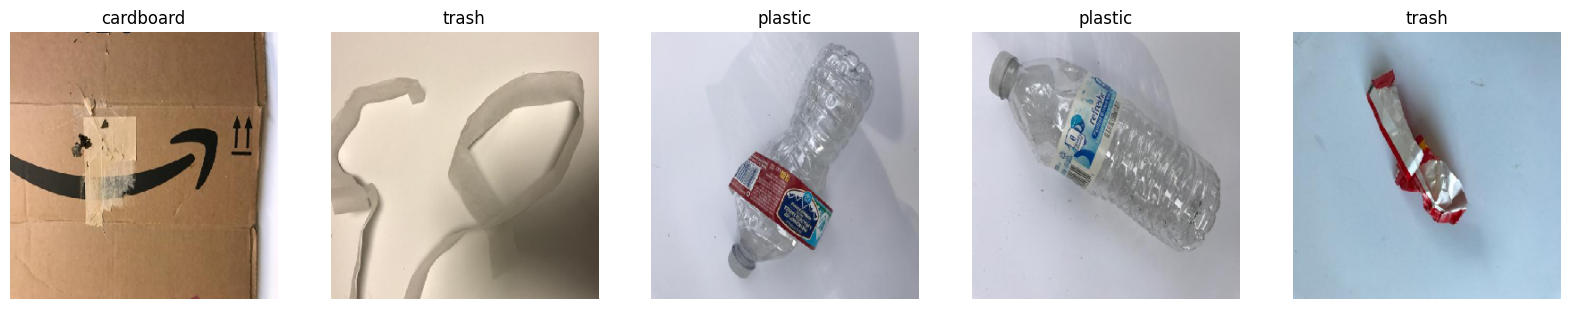

In [ ]:
base_path = '/content/garbage-classification/garbage classification/Garbage classification'
def display_random_images(base_path, num_images=5):
    """
    Display random images from different classes in the dataset.

    Parameters:
    - base_path: The base directory containing the dataset, with each subdirectory named after a class.
    - num_images: The number of random images to display.
    """
    # Get all class directories
    class_dirs = [os.path.join(base_path, d) for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    plt.figure(figsize=(20, 10))

    for i in range(num_images):
        # Randomly select a class directory
        class_dir = random.choice(class_dirs)
        class_name = os.path.basename(class_dir)

        # Get a random image from the class directory
        random_image_file = random.choice(os.listdir(class_dir))
        image_path = os.path.join(class_dir, random_image_file)

        # Load and display the image
        img = load_img(image_path, target_size=(300, 300))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.show()

display_random_images(base_path, num_images=5)


# **Dataset Preprocessing**

This coding part utilizes the `ImageDataGenerator` class to automatically handle image loading, preprocessing, augmentation, and the division of data into training and validation sets.

### ImageDataGenerator Configuration

- **train_datagen**: An instance of `ImageDataGenerator` configured with various image augmentation parameters (like `shear_range`, `zoom_range`, `width_shift_range`, `height_shift_range`, `horizontal_flip`, `vertical_flip`) and normalization (`rescale=1./255` to scale pixel values to the range [0, 1]). Additionally, a `validation_split` is defined to reserve a portion of the data for validation.
  
- **test_datagen**: Another `ImageDataGenerator` instance, but with minimal preprocessing (only `rescale` for normalization and `validation_split` for data splitting), typically used for validation or test data to evaluate the model.

### Data Loading and Augmentation

- **train_generator**: Uses `train_datagen.flow_from_directory` to load images from `base_path` for training. Images are resized to 300x300 pixels to ensure uniformity, batched into groups of 16, and categorized (`class_mode='categorical'`). It targets the 'training' subset of data based on the `validation_split` defined in `train_datagen`.

- **validation_generator**: Similar to `train_generator`, but uses `test_datagen` to load images for validation, ensuring no augmentation (beyond rescaling) is applied to this data.

### Label Mapping

- **labels**: Extracts the mapping of class indices to class names from `train_generator.class_indices` and inverts it (making the class index the key and the class name the value). This is useful for interpreting the model's predictions, converting numeric predictions back to understandable class names.



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


# **Preprocessing for Resnet50**


### Integration of Preprocessing Function in Data Augmentation

When training a convolutional neural network (CNN) with a base model pre-trained on ImageNet (e.g., ResNet), it's crucial to preprocess the input images in the same manner as was done for the original model training. This code snippet demonstrates how to incorporate the `preprocess_input` function from the ResNet family's preprocessing utilities into the `ImageDataGenerator` for both training and testing datasets. This ensures that images are correctly preprocessed for model compatibility, improving training efficiency and model accuracy.

### Training Data Generator

The `train_datagen` is configured with several data augmentation parameters:
- `shear_range`, `zoom_range`, `width_shift_range`, `height_shift_range`: These parameters introduce randomness in transformations to create variation in the training data, which helps the model generalize better to unseen data.
- `horizontal_flip` and `vertical_flip`: These settings randomly flip images horizontally and vertically, further augmenting the training data.
- `validation_split`: This parameter reserves a portion of the images for validation, ensuring that the model's performance is evaluated on unseen data.
- `preprocessing_function=preprocess_input`: This crucial addition applies the specific preprocessing needed for the ResNet model, adjusting the pixel values of images accordingly.

### Testing Data Generator

Similarly, `test_datagen` uses the `preprocess_input` function for preprocessing but is configured without the augmentation options, ensuring that the validation or test data undergoes the same preprocessing steps without any augmentation. This mirrors the real-world scenario where the model needs to predict on new, unaltered images.

### Purpose and Benefit

By integrating the `preprocess_input` function directly into the `ImageDataGenerator`, all images are automatically preprocessed in the correct way as they are loaded and augmented. This streamlined approach eliminates the need for manual preprocessing steps and ensures that the model receives data in the expected format, enhancing model training and eventual predictions.



In [ ]:
# Updating the ImageDataGenerator to include the preprocessing function
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Apply ResNet preprocessing
    validation_split=0.1
)

In [ ]:
# train_generator and validation_generator as previously defined, but now they'll preprocess inputs for ResNet50
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)



Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.




# **Implementing Transfer Learning with ResNet50**

Transfer learning leverages a pre-trained model (in this case, ResNet50 trained on the ImageNet dataset) to benefit a related task with less data, time, or computational resources than training a model from scratch. Here's how it's done:

#### Loading the Base Model
- **ResNet50**: We load ResNet50 with `weights='imagenet'` to utilize the knowledge it has gained from ImageNet. `include_top=False` excludes the top (or last fully connected) layers of the model, making it adaptable for our custom classification task. The `input_shape` is set to `(300, 300, 3)`, tailored to our dataset's image dimensions.

#### Freezing the Base Model Layers
- **Layer Freezing**: To retain the learned features, all layers of the base model are set to `trainable = False`. This prevents the weights from being updated during training, allowing us to utilize the extracted features as they are.

#### Adding Custom Layers
- **GlobalAveragePooling2D**: Reduces the spatial dimensions of the output from the base model to a vector. This step condenses the feature maps to a single value per map, reducing the total number of parameters and computation in the network.
- **Dense Layers**: A fully connected layer with 1024 neurons follows, introducing the capacity to learn high-level features specific to our dataset. The final dense layer outputs the predictions across `num_classes` categories using a softmax activation, turning logits into probabilities.

#### Model Compilation
- The model is compiled with the Adam optimizer and `categorical_crossentropy` loss function, suitable for multi-class classification. The primary metric for evaluation is accuracy.

#### Training the Model
- **Model Fitting**: The model is trained using `train_generator` for the input data, with a defined number of `steps_per_epoch` calculated by dividing the total number of samples by the batch size. The process is repeated for a specified number of epochs (10 in this case), with performance evaluated against a separate validation set provided by `validation_generator`.

#### Observations
- This method allows for significant model performance improvements on the target task by leveraging the generic features learned by ResNet50 on ImageNet and adapting them through additional training on a specific dataset.



In [ ]:
# Model parameters
num_classes = 6

In [ ]:
# Load ResNet50 base model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

for layer in base_model_resnet.layers:
    layer.trainable = False

x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_resnet = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)

model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
142/142 [==============================] - 64s 397ms/step - loss: 0.7164 - accuracy: 0.7615 - val_loss: 0.4531 - val_accuracy: 0.8333
Epoch 2/10
142/142 [==============================] - 54s 381ms/step - loss: 0.3483 - accuracy: 0.8867 - val_loss: 0.4912 - val_accuracy: 0.8083
Epoch 3/10
142/142 [==============================] - 54s 380ms/step - loss: 0.2493 - accuracy: 0.9133 - val_loss: 0.3533 - val_accuracy: 0.8917
Epoch 4/10
142/142 [==============================] - 54s 383ms/step - loss: 0.2092 - accuracy: 0.9248 - val_loss: 0.2130 - val_accuracy: 0.9042
Epoch 5/10
142/142 [==============================] - 54s 384ms/step - loss: 0.1565 - accuracy: 0.9429 - val_loss: 0.2671 - val_accuracy: 0.9167
Epoch 6/10
142/142 [==============================] - 54s 377ms/step - loss: 0.1386 - accuracy: 0.9482 - val_loss: 0.3423 - val_accuracy: 0.8792
Epoch 7/10
142/142 [==============================] - 54s 378ms/s

In [ ]:
# Save ResNet50 model
resnet50_model_path = os.path.join(models_directory, 'model_resnet.h5')
model_resnet.save(resnet50_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




# **Implementing Transfer Learning with VGG-16**

Transfer learning leverages a pre-trained model (in this case, VGG-16 trained on the ImageNet dataset) to benefit a related task with less data, time, or computational resources than training a model from scratch. Similarly to ResNet50, here's how it's done:

#### Loading the Base Model
- **VGG-16**: We load VGG-16 with `weights='imagenet'` to utilize the knowledge it has gained from ImageNet. `include_top=False` excludes the top (or last fully connected) layers of the model, making it adaptable for our custom classification task. The `input_shape` is set to `(300, 300, 3)`, tailored to our dataset's image dimensions.

#### Freezing the Base Model Layers
- **Layer Freezing**: To retain the learned features, all layers of the base model are set to `trainable = False`. This prevents the weights from being updated during training, allowing us to utilize the extracted features as they are.

#### Adding Custom Layers
- **GlobalAveragePooling2D**: Reduces the spatial dimensions of the output from the base model to a vector. This step condenses the feature maps to a single value per map, reducing the total number of parameters and computation in the network.
- **Dense Layers**: A fully connected layer with 1024 neurons follows, introducing the capacity to learn high-level features specific to our dataset. The final dense layer outputs the predictions across `num_classes` categories using a softmax activation, turning logits into probabilities.

#### Model Compilation
- The model is compiled with the Adam optimizer and `categorical_crossentropy` loss function, suitable for multi-class classification. The primary metric for evaluation is accuracy.

#### Training the Model
- **Model Fitting**: The model is trained using `train_generator` for the input data, with a defined number of `steps_per_epoch` calculated by dividing the total number of samples by the batch size. The process is repeated for a specified number of epochs (10 in this case), with performance evaluated against a separate validation set provided by `validation_generator`.

#### Observations
- This method allows for significant model performance improvements on the target task by leveraging the generic features learned by ResNet50 on ImageNet and adapting them through additional training on a specific dataset.

In [ ]:
# Load VGG-16 base model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

for layer in base_model_vgg16.layers:
    layer.trainable = False

x = base_model_vgg16.output
x = Flatten()(x)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
predictions_vgg16 = Dense(num_classes, activation='softmax')(x)

model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg16)

model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
142/142 [==============================] - 67s 420ms/step - loss: 2.0550 - accuracy: 0.5332 - val_loss: 0.9962 - val_accuracy: 0.5958
Epoch 2/10
142/142 [==============================] - 57s 400ms/step - loss: 0.9351 - accuracy: 0.6491 - val_loss: 0.9992 - val_accuracy: 0.6875
Epoch 3/10
142/142 [==============================] - 55s 384ms/step - loss: 0.8838 - accuracy: 0.6920 - val_loss: 0.8635 - val_accuracy: 0.6458
Epoch 4/10
142/142 [==============================] - 56s 391ms/step - loss: 0.7631 - accuracy: 0.7137 - val_loss: 0.9993 - val_accuracy: 0.7083
Epoch 5/10
142/142 [==============================] - 56s 391ms/step - loss: 0.6537 - accuracy: 0.7451 - val_loss: 0.7433 - val_accuracy: 0.7458
Epoch 6/10
142/142 [==============================] - 55s 390ms/step - loss: 0.6014 - accuracy: 0.7748 - val_loss: 0.7416 - val_accuracy: 0.7375
Epoch 7/10
142/142 [==============================] - 56s 392ms/s

In [ ]:
# Save VGG16 model
vgg16_model_path = os.path.join(models_directory, 'model_vgg16.h5')
model_vgg16.save(vgg16_model_path)

# Ensemble Learning: Bagging

Ensemble learning involves combining multiple models to improve the overall performance of the system. The basic idea behind it is that by aggregating the predictions of multiple models, it's possible to achieve better results than any single model could achieve on its own.

In this project, we will explore the use of bagging on resnet50 and vgg16.

Baggin is a technique to enhance the performance of our transfer learning model based on ResNet50 and VGG16 for image classification tasks. Bagging involves training multiple instances of the base learning algorithm (in this case would be ResNet50 and VGG16) on different subsets of the training data and then combining their predictions to obtain a final prediction.

Here's an overview of what we did:
*   Previously we had trained a model each using ResNet50 and VGG16
*   We now use these 2 trained model to perform bagging via voting using the function `perform_bagging`. This function takes input data X (in this case, the validation data generator) and a list of models. It returns the final predictions obtained through voting.
*   We then set the shuffle on the validation generator to false
*   Then finally call the `perform_bagging` function with the validation generator and the list of models to obtain the final predictions.


In [ ]:
def perform_bagging(X, models):
    ensemble_predictions = []
    for model_path in models:
        model = load_model(model_path)
        predictions = model.predict(X)
        ensemble_predictions.append(predictions)
    ensemble_predictions = np.array(ensemble_predictions)
    final_predictions = np.argmax(np.sum(ensemble_predictions, axis=0), axis=1)
    return final_predictions

# Ensemble Learning: Stacking

In stacking, multiple base models are trained independently on the entire training dataset.
* Instead of directly combining the predictions of the base models, the predictions are used as features for a meta-model (also known as a blender or a meta-learner).
* The meta-model is trained on the predictions made by the base models, learning how to best combine their outputs to make the final prediction.

Stacking aims to leverage the strengths of different base models by learning a higher-level function that effectively combines their predictions, potentially leading to better performance than any individual base model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load validation data
true_classes = validation_generator.classes

In [ ]:
# Reshape predictions into matrices
resnet_predictions = model_resnet.predict(validation_generator)
vgg16_predictions = model_vgg16.predict(validation_generator)

# Combine predictions of renet50 & vgg16 into a new feature matrix
stacking_features = np.concatenate((vgg16_predictions, vgg16_predictions), axis=1)

# Train a meta-model on the new feature matrix using RandomForest Classifier
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(stacking_features, true_classes)

16/16 [==============================] - 8s 485ms/step


RandomForestClassifier(random_state=42)

In [ ]:
import joblib

# save the meta model
meta_model_path = os.path.join(models_directory, 'meta_model.pkl')
joblib.dump(meta_model, meta_model_path)

['/content/drive/My Drive/models/meta_model.pkl']

# Evaluation

In [ ]:
validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0,
    shuffle=False
)

# Load validation data
true_classes = validation_generator.classes

Found 251 images belonging to 6 classes.


In [ ]:
# Perform predictions for ResNet50
resnet_predictions_class = model_resnet.predict(validation_generator).argmax(axis=1)

# Perform predictions for VGG16
vgg16_predictions_class = model_vgg16.predict(validation_generator).argmax(axis=1)

16/16 [==============================] - 2s 127ms/step


In [ ]:
# Perform bagging predictions
bagging_predictions = perform_bagging(validation_generator, [resnet50_model_path, vgg16_model_path])

16/16 [==============================] - 2s 121ms/step


In [ ]:
# Use the trained meta-model to predict classes based on stacking features
stacking_predictions = meta_model.predict(stacking_features)

## Accuracy

In [ ]:
# Calculate accuracy for bagging
bagging_accuracy = accuracy_score(true_classes, bagging_predictions)
print("Accuracy of Bagging (ResNet50 + VGG16):", bagging_accuracy)

stacking_accuracy = accuracy_score(true_classes, stacking_predictions)
print("Accuracy of Stacking (ResNet50 + VGG16):", stacking_accuracy)

# Calculate accuracy for ResNet50
resnet_accuracy = accuracy_score(true_classes, resnet_predictions_class)
print("Accuracy of ResNet50:", resnet_accuracy)

# Calculate accuracy for VGG16
vgg16_accuracy = accuracy_score(true_classes, vgg16_predictions_class)
print("Accuracy of VGG16:", vgg16_accuracy)

Accuracy of Bagging (ResNet50 + VGG16): 0.9123505976095617
Accuracy of Stacking (ResNet50 + VGG16): 0.9322709163346613
Accuracy of ResNet50: 0.9243027888446215
Accuracy of VGG16: 0.7689243027888446


## F1 Score

In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 score for bagging
bagging_f1_score = f1_score(true_classes, bagging_predictions, average='weighted')
print("F1 Score of Bagging (ResNet50 + VGG16):", bagging_f1_score)

# Calculate F1 score for stacking
stacking_f1_score = f1_score(true_classes, stacking_predictions, average='weighted')
print("F1 Score of Stacking (ResNet50 + VGG16):", stacking_f1_score)

# Calculate F1 score for ResNet50
resnet_f1_score = f1_score(true_classes, resnet_predictions_class, average='weighted')
print("F1 Score of ResNet50:", resnet_f1_score)

# Calculate F1 score for VGG16
vgg16_f1_score = f1_score(true_classes, vgg16_predictions_class, average='weighted')
print("F1 Score of VGG16:", vgg16_f1_score)

F1 Score of Bagging (ResNet50 + VGG16): 0.9121490668062721
F1 Score of Stacking (ResNet50 + VGG16): 0.9334300378957021
F1 Score of ResNet50: 0.9240417711039396
F1 Score of VGG16: 0.7716666776382977


## Visualizing Confusion Matrix Using Heatmaps

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

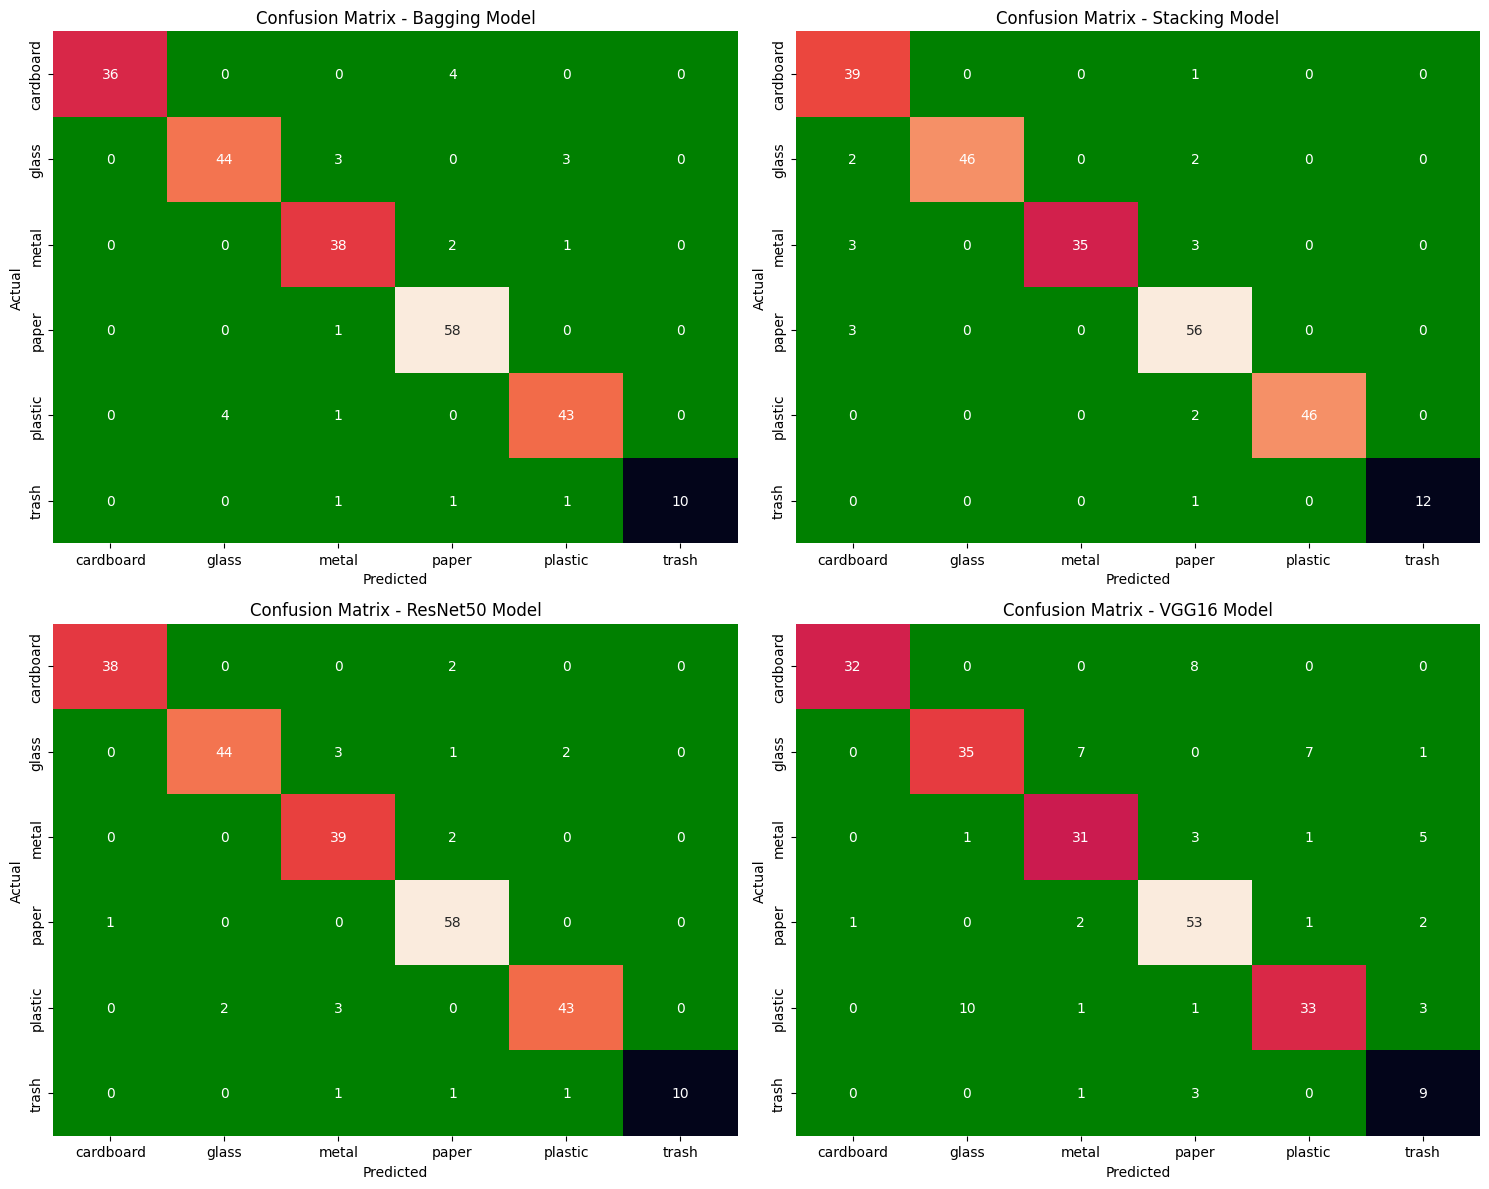

In [ ]:
# Compute confusion matrices
bagging_cm = confusion_matrix(true_classes, bagging_predictions)
stacking_cm = confusion_matrix(true_classes, stacking_predictions)
resnet_cm = confusion_matrix(true_classes, resnet_predictions_class)
vgg16_cm = confusion_matrix(true_classes, vgg16_predictions_class)

# Define class labels
class_labels = list(validation_generator.class_indices.keys())

# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, class_labels, model_name, ax):
    mask = np.zeros_like(cm, dtype=bool)
    np.fill_diagonal(mask, True)
    confusion_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    sns.heatmap(confusion_df, annot=True, fmt='g', mask=~mask,cbar=False, ax=ax)
    sns.heatmap(confusion_df, annot=True, fmt='g', mask=mask, cmap=['green'],cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name} Model')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot confusion matrices for each model
plot_confusion_matrix(bagging_cm, class_labels, 'Bagging', axs[0, 0])
plot_confusion_matrix(stacking_cm, class_labels, 'Stacking', axs[0, 1])
plot_confusion_matrix(resnet_cm, class_labels, 'ResNet50', axs[1, 0])
plot_confusion_matrix(vgg16_cm, class_labels, 'VGG16', axs[1, 1])

# Adjust layout
plt.tight_layout()
plt.show()
